<a href="https://colab.research.google.com/github/AbhigyanPandey08/Crowdsourced-Air-Quality-Monitoring-and-Data-Fusion-with-Adaptive-Heuristic-Optimization/blob/main/AQIpapernew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell A
import os, sys, glob, json
from pathlib import Path
!pip install --quiet pykalman
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from pykalman import KalmanFilter
import seaborn as sns
from scipy.stats import pearsonr
SEED = 42
np.random.seed(SEED)
DATA_PATH = "/content/AQI Indian Cities.csv"
WORKDIR = "/content/India_AQI_workdir"
RESULTS_DIR = os.path.join(WORKDIR, "results_citywise")
FIG_DIR = os.path.join(RESULTS_DIR, "figures")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)
# Evaluation metrics
def rmse(ref, pred):
    return float(np.sqrt(mean_squared_error(ref, pred)))
def mae(ref, pred):
    return float(mean_absolute_error(ref, pred))
# bias(ref, pred): positive means prediction > reference on average
def bias(ref, pred):
    return float(np.mean(np.array(pred) - np.array(ref)))
def safe_corr(a, b):
    a, b = np.array(a), np.array(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    if mask.sum() < 2:
        return np.nan
    return float(np.corrcoef(a[mask], b[mask])[0, 1])
# Pollutant name normalization helpers (if needed)
POLLUTANT_VARIANTS = {
    "pm2.5": "PM2.5", "pm2_5": "PM2.5", "pm25": "PM2.5",
    "pm10": "PM10", "no2": "NO2", "so2": "SO2",
    "co": "CO", "o3": "O3", "aqi": "AQI"
}
def normalize_column_names(cols):
    new = {}
    for c in cols:
        k = c.strip().lower().replace(" ", "").replace("-", "").replace(".", "_")
        if k in POLLUTANT_VARIANTS:
            new[c] = POLLUTANT_VARIANTS[k]
        else:
            lc = c.strip().lower()
            matched = None
            for key in POLLUTANT_VARIANTS:
                if key in lc:
                    matched = POLLUTANT_VARIANTS[key]
                    break
            new[c] = matched if matched else c
    return new
print("Setup complete. DATA_PATH:", DATA_PATH, "WORKDIR:", WORKDIR)
# Save
try:
    versions = {
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "sklearn": __import__("sklearn").__version__,
        "pykalman": __import__("pykalman").__version__,
        "seed": SEED
    }
    os.makedirs(WORKDIR, exist_ok=True)
    with open(os.path.join(WORKDIR, "versions.json"), "w") as f:
        json.dump(versions, f, indent=2)
except Exception as e:
    print("Warning: Could not save versions.json:", e)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.1/252.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.8/159.8 kB 8.5 MB/s eta 0:00:00
Setup complete. DATA_PATH: /content/AQI Indian Cities.csv WORKDIR: /content/India_AQI_workdir


In [ ]:
# Cell B
assert os.path.exists(DATA_PATH), f"DATA_PATH not found: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
print("Columns:", df.columns.tolist())
# Normalize column names using variants
df = df.rename(columns=normalize_column_names(df.columns))
# Detect Date and City columns
date_cols = [c for c in df.columns if c.lower() in ("date", "day", "timestamp")]
city_cols = [c for c in df.columns if any(k in c.lower() for k in ["city", "location", "site"])]

if not date_cols:
    raise SystemExit("No date column found; rename it to 'Date'")
if not city_cols:
    raise SystemExit("No city column found; rename it to 'City'")

# Standardize names
df = df.rename(columns={date_cols[0]: "Date", city_cols[0]: "City"})
df["Date"] = pd.to_datetime(df["Date"], errors="coerce", dayfirst=True)
df["City"] = df["City"].astype(str).str.strip().str.title()

# Expected pollutants
expected_pollutants = ["PM2.5", "PM10", "NO2", "SO2", "CO", "O3", "AQI"]
present = [c for c in expected_pollutants if c in df.columns]
print("Detected expected columns:", present)
# Coerce non City/Date columns to numeric
for c in df.columns:
    if c not in ["City", "Date"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
# Drop rows missing City or Date
df = df.dropna(subset=["City", "Date"]).sort_values(["City", "Date"]).reset_index(drop=True)
print("After cleaning rows:", df.shape)
# Save master CSV
MASTER_CSV = os.path.join(WORKDIR, "India_AQI_master_cleaned.csv")
os.makedirs(WORKDIR, exist_ok=True)
df.to_csv(MASTER_CSV, index=False)
print("Saved MASTER_CSV:", MASTER_CSV)

Raw shape: (36802, 9)
Columns: ['City', 'Date', 'AQI', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
Detected expected columns: ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'AQI']
After cleaning rows: (36802, 9)


/tmp/ipython-input-1918470288.py:19: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce", dayfirst=True)


Saved MASTER_CSV: /content/India_AQI_workdir/India_AQI_master_cleaned.csv


In [ ]:
# Cell C: Robust Kalman SMOOTHING-based AQI imputation (produces AQI_kf column)
df_master = pd.read_csv(MASTER_CSV, parse_dates=["Date"])
cities = df_master["City"].unique()
df_master["AQI_kf"] = np.nan

def kalman_fill_series(series):
    """Return filled series using pykalman EM+smooth or robust fallback."""
    y = np.array(series, dtype=float)
    mask = np.isnan(y)
    if y.size < 3 or np.all(mask):
        s = pd.Series(y)
        s = s.interpolate().fillna(method="ffill").fillna(method="bfill")
        if s.isna().any():
            s = s.fillna(s.median() if not np.isnan(s.median()) else 0.0)
        return s.values
    observed = y[~mask]
    if np.nanstd(observed) == 0:
        s = pd.Series(y).interpolate().fillna(observed.mean())
        return s.values
    try:
        kf = KalmanFilter(
            transition_matrices=[1.],
            observation_matrices=[1.],
            initial_state_mean=float(np.nanmean(observed)),
            initial_state_covariance=1.0,
            observation_covariance=np.var(observed) if np.var(observed) > 0 else 1.0,
            transition_covariance=1e-3
        )
        kf = kf.em(y, n_iter=5)
        state_means, _ = kf.smooth(y)
        return state_means.flatten()
    except Exception:
        s = pd.Series(y).interpolate(
            method='time' if isinstance(series.index, pd.DatetimeIndex) else 'linear'
        )
        s = s.fillna(method='ffill').fillna(method='bfill')
        if s.isna().any():
            s = s.fillna(np.nanmedian(observed))
        return s.values

for city in tqdm(cities, desc="Kalman AQI fill"):
    sub = df_master[df_master["City"] == city].sort_values("Date").copy()
    series = sub.set_index("Date")["AQI"] if "AQI" in sub.columns else None
    if series is not None and not series.isna().all():
        filled = kalman_fill_series(series)
    else:
        # fallback: use PM2.5 as proxy if available
        if "PM2.5" in sub.columns and not sub["PM2.5"].isna().all():
            proxy = sub["PM2.5"].fillna(method="ffill").fillna(method="bfill").values
            filled = proxy
        else:
            filled = np.full(len(sub), np.nan)
    df_master.loc[sub.index, "AQI_kf"] = filled

MASTER_WITH_KF = os.path.join(WORKDIR, "India_AQI_master_withAQIkf.csv")
df_master.to_csv(MASTER_WITH_KF, index=False)
print("Saved with AQI_kf:", MASTER_WITH_KF)

Kalman AQI fill:   0%|          | 0/68 [00:00<?, ?it/s]/tmp/ipython-input-4165856721.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate().fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-4165856721.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate().fillna(method="ffill").fillna(method="bfill")
Kalman AQI fill:   6%|▌         | 4/68 [00:10<02:40,  2.51s/it]/tmp/ipython-input-4165856721.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate().fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-4165856721.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead

Saved with AQI_kf: /content/India_AQI_workdir/India_AQI_master_withAQIkf.csv


In [ ]:
# Cell D: Weighted Regression fusion (per city)
df_master = pd.read_csv(MASTER_WITH_KF, parse_dates=["Date"])
pollutants = [p for p in ["PM2.5", "PM10", "NO2", "SO2", "CO", "O3"] if p in df_master.columns]

def weighted_regression_matrix(X, max_iter=50, eps=1e-9):
    # X: (n_samples, n_sensors)
    n_sensors = X.shape[1]
    if n_sensors == 0:
        raise ValueError("No pollutant columns found")
    w = np.ones(n_sensors) / n_sensors
    for _ in range(max_iter):
        y_star = X.dot(w) / (w.sum() + eps)
        residuals = np.nanmean(np.abs(X - y_star[:, None]), axis=0)
        if np.isnan(residuals).all():
            residuals = np.ones_like(residuals)
        else:
            residuals = np.where(np.isnan(residuals), residuals[~np.isnan(residuals)].mean(), residuals)
        w_new = 1.0 / (eps + residuals)
        w_new = np.clip(w_new, 1e-12, None)
        w_new /= w_new.sum()
        if np.linalg.norm(w_new - w) < 1e-6:
            w = w_new
            break
        w = w_new
    fused = X.dot(w)
    return fused, w

results = []
for city in tqdm(df_master["City"].unique(), desc="WR fusion per city"):
    sub = df_master[df_master["City"] == city].sort_values("Date").copy()
    if len(sub) < 5:
        continue
    X_cols = [c for c in pollutants if c in sub.columns]
    if len(X_cols) < 1:
        continue
    X = sub[X_cols].fillna(method="ffill").fillna(method="bfill").values
    fused_wr, weights = weighted_regression_matrix(X)
    sub["fused_WR"] = fused_wr
    outp = os.path.join(RESULTS_DIR, f"{city}_WR.csv")
    sub.to_csv(outp, index=False)
    results.append({
        "City": city,
        "n_days": len(sub),
        "weights": dict(zip(X_cols, map(float, weights)))
    })

pd.DataFrame(results).to_csv(os.path.join(RESULTS_DIR, "wr_summary.csv"), index=False)
print("Weighted Regression outputs saved to", RESULTS_DIR)


WR fusion per city:   0%|          | 0/68 [00:00<?, ?it/s]/tmp/ipython-input-885363052.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = sub[X_cols].fillna(method="ffill").fillna(method="bfill").values
/tmp/ipython-input-885363052.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = sub[X_cols].fillna(method="ffill").fillna(method="bfill").values
/tmp/ipython-input-885363052.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = sub[X_cols].fillna(method="ffill").fillna(method="bfill").values
/tmp/ipython-input-885363052.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = sub[X_cols].fillna(method="ffill").

Weighted Regression outputs saved to /content/India_AQI_workdir/results_citywise


In [ ]:
# Cell E: Kalman FILTERING over fused_WR
def kalman_smooth_1d(z, Q=1e-3, R=1e-2):
    # z: 1d array (may contain NaN) -> return smoothed array (no NaN)
    z = np.array(z, dtype=float)
    n = len(z)
    if n == 0:
        return z
    s = pd.Series(z)
    s = s.interpolate().fillna(method='ffill').fillna(method='bfill')
    zf = s.values
    x = np.zeros(n)
    P = 1.0
    x[0] = zf[0]
    for t in range(1, n):
        x_pred = x[t-1]
        P_pred = P + Q
        K = P_pred / (P_pred + R)
        x[t] = x_pred + K * (zf[t] - x_pred)
        P = (1 - K) * P_pred
    return x

files_wr = sorted(glob.glob(os.path.join(RESULTS_DIR, "*_WR.csv")))
for f in tqdm(files_wr, desc="KF smoothing on WR"):
    dfc = pd.read_csv(f, parse_dates=["Date"], infer_datetime_format=True)
    if "fused_WR" not in dfc.columns:
        continue
    fused_wr = dfc["fused_WR"].values
    fused_kf = kalman_smooth_1d(fused_wr, Q=1e-3, R=1e-2)
    dfc["fused_KF"] = fused_kf
    outp = f.replace("_WR.csv", "_WRKF.csv")
    dfc.to_csv(outp, index=False)

print("Saved WRKF files.")


KF smoothing on WR:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipython-input-2762397207.py:24: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfc = pd.read_csv(f, parse_dates=["Date"], infer_datetime_format=True)
/tmp/ipython-input-2762397207.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate().fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-2762397207.py:24: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dfc = pd.read_csv(f, parse

Saved WRKF files.


In [ ]:
# Cell F1: GA–PSO hybrid optimizer for weights
def ga_pso_optimize_weights(
    X,
    y_ref,
    pop_size=40,
    ga_gens=40,
    pso_iters=40,
    elite_frac=0.1,
    inertia=0.7,
    c1=1.5,
    c2=1.5,
    seed=42
):
    """
    Hybrid GA–PSO optimizer for sensor reliability weights.
    X: (n_samples, n_sensors) pollutant matrix
    y_ref: (n_samples,) reference AQI (AQI_kf or AQI)
    Returns:
        best_w: final GA–PSO-optimized weight vector (sum=1, non-negative)
        w_hist: np.array [n_generations_total, n_sensors] of best weights over time
    """
    rng = np.random.default_rng(seed)

    X = np.asarray(X, float)
    y_ref = np.asarray(y_ref, float)
    mask_valid = ~np.isnan(y_ref) & ~np.isnan(X).all(axis=1)
    if mask_valid.sum() < 5:
        raise ValueError("Not enough valid samples for optimization")

    Xv = X[mask_valid]
    yv = y_ref[mask_valid]
    n_sensors = Xv.shape[1]

    def fitness(w):
        w = np.clip(w, 0, None)
        s = w.sum()
        if s <= 0:
            return np.inf
        w = w / s
        pred = Xv.dot(w)
        return np.sqrt(np.mean((yv - pred) ** 2))

    # Stage 1: GA
    n_elite = max(2, int(pop_size * elite_frac))

    pop = rng.random((pop_size, n_sensors))
    pop = pop / (pop.sum(axis=1, keepdims=True) + 1e-9)

    fit = np.array([fitness(ind) for ind in pop])
    w_hist = []

    for _ in range(ga_gens):
        idx = np.argsort(fit)
        pop = pop[idx]
        fit = fit[idx]

        elites = pop[:n_elite].copy()
        best = elites[0]
        w_hist.append(best)

        new_pop = elites.tolist()
        while len(new_pop) < pop_size:
            p1, p2 = pop[rng.choice(pop_size, size=2, replace=False)]
            alpha = rng.random(n_sensors)
            child = alpha * p1 + (1 - alpha) * p2
            if rng.random() < 0.2:
                child += rng.normal(0, 0.03, size=n_sensors)
            child = np.clip(child, 0, None)
            s = child.sum()
            child = child / s if s > 0 else np.ones_like(child) / n_sensors
            new_pop.append(child)

        pop = np.array(new_pop)
        fit = np.array([fitness(ind) for ind in pop])

    idx = np.argsort(fit)
    pop = pop[idx]
    fit = fit[idx]
    elites = pop[:n_elite].copy()

    # ----- Stage 2: PSO -----
    n_particles = max(n_elite, 5)
    if elites.shape[0] < n_particles:
        extra = rng.random((n_particles - elites.shape[0], n_sensors))
        extra = extra / (extra.sum(axis=1, keepdims=True) + 1e-9)
        positions = np.vstack([elites, extra])
    else:
        positions = elites[:n_particles].copy()

    velocities = np.zeros_like(positions)
    p_best = positions.copy()
    p_best_fit = np.array([fitness(p) for p in positions])

    g_idx = np.argmin(p_best_fit)
    g_best = p_best[g_idx].copy()
    g_best_fit = p_best_fit[g_idx]

    for _ in range(pso_iters):
        for i in range(n_particles):
            r1 = rng.random(n_sensors)
            r2 = rng.random(n_sensors)

            velocities[i] = (
                inertia * velocities[i]
                + c1 * r1 * (p_best[i] - positions[i])
                + c2 * r2 * (g_best    - positions[i])
            )

            positions[i] = positions[i] + velocities[i]
            positions[i] = np.clip(positions[i], 0, None)
            s = positions[i].sum()
            positions[i] = positions[i] / s if s > 0 else np.ones_like(positions[i]) / n_sensors

            f_new = fitness(positions[i])
            if f_new < p_best_fit[i]:
                p_best[i] = positions[i].copy()
                p_best_fit[i] = f_new
                if f_new < g_best_fit:
                    g_best = positions[i].copy()
                    g_best_fit = f_new

        w_hist.append(g_best.copy())

    w_hist = np.vstack(w_hist) if len(w_hist) > 0 else np.zeros((0, n_sensors))
    best_w = g_best / (g_best.sum() + 1e-9)
    return best_w, w_hist


# Cell F2: Apply GA–PSO per city
files_wrkf = sorted(glob.glob(os.path.join(RESULTS_DIR, "*_WRKF.csv")))
print("Found WRKF files:", len(files_wrkf))

for f in tqdm(files_wrkf, desc="GA–PSO fusion per city"):
    dfc = pd.read_csv(f, parse_dates=["Date"])
    city = os.path.basename(f).replace("_WRKF.csv", "")

    # reference
    if "AQI_kf" in dfc.columns and not dfc["AQI_kf"].isna().all():
        y_ref = dfc["AQI_kf"].values
    elif "AQI" in dfc.columns and not dfc["AQI"].isna().all():
        y_ref = dfc["AQI"].values
    else:
        print(f"Skipping {city}: no AQI or AQI_kf reference.")
        continue

    sensor_cols = [c for c in ["PM2.5", "PM10", "NO2", "SO2", "CO", "O3"] if c in dfc.columns]
    if len(sensor_cols) < 2:
        print(f"Skipping {city}: not enough pollutant columns.")
        continue

    X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)

    try:
        best_w, w_hist = ga_pso_optimize_weights(
            X, y_ref,
            pop_size=40,
            ga_gens=40,
            pso_iters=40,
            elite_frac=0.1,
            inertia=0.7,
            c1=1.5,
            c2=1.5,
            seed=SEED
        )
    except Exception as e:
        print(f"GA–PSO failed for {city}:", e)
        continue

    fused_best = X.dot(best_w)
    dfc["fused_best"] = fused_best

    outp = os.path.join(RESULTS_DIR, f"{city}_Best.csv")
    dfc.to_csv(outp, index=False)

    w_hist_path = os.path.join(RESULTS_DIR, f"{city}_weights_hist.npy")
    np.save(w_hist_path, w_hist)

    weights_dict = dict(zip(sensor_cols, np.round(best_w, 4)))
    print(f"{city}: GA–PSO final weights:", weights_dict)

print("GA–PSO fusion complete. *_Best.csv files written to", RESULTS_DIR)


Found WRKF files: 27


GA–PSO fusion per city:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:   4%|▎         | 1/27 [00:00<00:04,  5.64it/s]

Ahmedabad: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(1.0), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.0)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:   7%|▋         | 2/27 [00:00<00:03,  6.53it/s]

Aizawl: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.8757), 'NO2': np.float64(0.0), 'SO2': np.float64(0.1243), 'CO': np.float64(0.0), 'O3': np.float64(0.0)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  11%|█         | 3/27 [00:00<00:03,  6.48it/s]

Amaravati: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.7047), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.2953)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  15%|█▍        | 4/27 [00:00<00:03,  6.05it/s]

Amritsar: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.6592), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.3408)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  19%|█▊        | 5/27 [00:00<00:05,  4.36it/s]

Bangalore: GA–PSO final weights: {'PM2.5': np.float64(0.1689), 'PM10': np.float64(0.1726), 'NO2': np.float64(0.2055), 'SO2': np.float64(0.2198), 'CO': np.float64(0.0312), 'O3': np.float64(0.2019)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  22%|██▏       | 6/27 [00:01<00:05,  3.88it/s]

Bengaluru: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.8879), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.1121)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  26%|██▌       | 7/27 [00:01<00:04,  4.10it/s]

Bhopal: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.6945), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.3055)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  30%|██▉       | 8/27 [00:01<00:04,  4.00it/s]

Brajrajnagar: GA–PSO final weights: {'PM2.5': np.float64(0.0833), 'PM10': np.float64(0.8527), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.064)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  33%|███▎      | 9/27 [00:01<00:04,  4.23it/s]

Chandigarh: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.8181), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.1819)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  37%|███▋      | 10/27 [00:02<00:04,  3.48it/s]/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  41%|████      | 11/27 [00:02<00:04,  3.85it/s]

Chennai: GA–PSO final weights: {'PM2.5': np.float64(0.1103), 'PM10': np.float64(0.8897), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.0)}
Coimbatore: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(1.0), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.0)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  44%|████▍     | 12/27 [00:02<00:04,  3.37it/s]

Delhi: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.6887), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.1474), 'O3': np.float64(0.164)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  48%|████▊     | 13/27 [00:03<00:03,  3.61it/s]

Ernakulam: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.0), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(1.0)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  52%|█████▏    | 14/27 [00:03<00:03,  3.58it/s]

Gurugram: GA–PSO final weights: {'PM2.5': np.float64(0.044), 'PM10': np.float64(0.956), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.0)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  56%|█████▌    | 15/27 [00:03<00:03,  3.72it/s]

Guwahati: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.5737), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.4263)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  59%|█████▉    | 16/27 [00:04<00:03,  3.38it/s]/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  63%|██████▎   | 17/27 [00:04<00:02,  3.87it/s]

Hyderabad: GA–PSO final weights: {'PM2.5': np.float64(0.1963), 'PM10': np.float64(0.7535), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.0502)}
Jaipur: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.7732), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.2268)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  67%|██████▋   | 18/27 [00:04<00:02,  4.39it/s]/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  70%|███████   | 19/27 [00:04<00:01,  4.99it/s]

Jorapokhar: GA–PSO final weights: {'PM2.5': np.float64(0.5811), 'PM10': np.float64(0.4189), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.0)}
Kochi: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.9395), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0605), 'CO': np.float64(0.0), 'O3': np.float64(0.0)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  74%|███████▍  | 20/27 [00:04<00:01,  5.43it/s]/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  78%|███████▊  | 21/27 [00:04<00:01,  5.44it/s]

Kolkata: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.578), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.422)}
Lucknow: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(1.0), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.0)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  81%|████████▏ | 22/27 [00:05<00:01,  4.93it/s]/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  85%|████████▌ | 23/27 [00:05<00:00,  5.22it/s]

Mumbai: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.4744), 'NO2': np.float64(0.0361), 'SO2': np.float64(0.0), 'CO': np.float64(0.4081), 'O3': np.float64(0.0815)}
Patna: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(1.0), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.0)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  89%|████████▉ | 24/27 [00:05<00:00,  5.75it/s]/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  93%|█████████▎| 25/27 [00:05<00:00,  6.04it/s]

Shillong: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.053), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.947)}
Talcher: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.5628), 'NO2': np.float64(0.0), 'SO2': np.float64(0.4372), 'CO': np.float64(0.0), 'O3': np.float64(0.0)}


/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city:  96%|█████████▋| 26/27 [00:05<00:00,  6.11it/s]/tmp/ipython-input-3815198368.py:151: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
GA–PSO fusion per city: 100%|██████████| 27/27 [00:05<00:00,  4.57it/s]

Thiruvananthapuram: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(1.0), 'NO2': np.float64(0.0), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.0)}
Visakhapatnam: GA–PSO final weights: {'PM2.5': np.float64(0.0), 'PM10': np.float64(0.6792), 'NO2': np.float64(0.2553), 'SO2': np.float64(0.0), 'CO': np.float64(0.0), 'O3': np.float64(0.0654)}
GA–PSO fusion complete. *_Best.csv files written to /content/India_AQI_workdir/results_citywise


In [ ]:
# Cell G: Create summary_metrics.csv (robust)
RESULTS_DIR = "/content/India_AQI_workdir/results_citywise"
os.makedirs(RESULTS_DIR, exist_ok=True)

def safe_rmse(a, b):
    a, b = np.array(a), np.array(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    if mask.sum() < 2:
        return np.nan
    return np.sqrt(mean_squared_error(a[mask], b[mask]))

def safe_mae(a, b):
    a, b = np.array(a), np.array(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    if mask.sum() < 2:
        return np.nan
    return mean_absolute_error(a[mask], b[mask])

def safe_bias(a, b):
    a, b = np.array(a), np.array(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    if mask.sum() < 2:
        return np.nan
    return np.mean(b[mask] - a[mask])

rows = []
best_files = sorted(glob.glob(os.path.join(RESULTS_DIR, "*_Best.csv")))
wrkf_files  = sorted(glob.glob(os.path.join(RESULTS_DIR, "*_WRKF.csv")))
wr_files    = sorted(glob.glob(os.path.join(RESULTS_DIR, "*_WR.csv")))

all_files = sorted(set(best_files + wrkf_files + wr_files))

for f in all_files:
    base = os.path.basename(f)
    city = base.split('_')[0] if "_" in base else base.replace(".csv","")

    try:
        df = pd.read_csv(f, parse_dates=['Date'], infer_datetime_format=True)
    except Exception:
        df = pd.read_csv(f)

    if 'AQI_kf' in df.columns and not df['AQI_kf'].isna().all():
        ref_col = 'AQI_kf'
    elif 'AQI' in df.columns and not df['AQI'].isna().all():
        ref_col = 'AQI'
    else:
        ref_col = None

    if f.endswith("_Best.csv"):
        fused_col = "fused_best"
    elif f.endswith("_WRKF.csv"):
        fused_col = "fused_KF"
    elif f.endswith("_WR.csv"):
        fused_col = "fused_WR"
    else:
        fused_col = None
        for c in ["fused_best", "fused_KF", "fused_WR"]:
            if c in df.columns:
                fused_col = c
                break

    if ref_col and fused_col and fused_col in df.columns:
        ref = df[ref_col].values
        fused = df[fused_col].values
        mask = ~np.isnan(ref) & ~np.isnan(fused)

        r = safe_rmse(ref, fused)
        m = safe_mae(ref, fused)
        b = safe_bias(ref, fused)
        c = safe_corr(ref, fused)

        rows.append({
            "City": city,
            "Stage": fused_col,
            "Ref": ref_col,
            "RMSE": float(r) if not np.isnan(r) else None,
            "MAE": float(m) if not np.isnan(m) else None,
            "Bias": float(b) if not np.isnan(b) else None,
            "Corr": float(c) if not np.isnan(c) else None,
            "n_valid": int(mask.sum())
        })
    else:
        rows.append({
            "City": city,
            "Stage": fused_col if fused_col else "none",
            "Ref": ref_col if ref_col else "none",
            "RMSE": None,
            "MAE": None,
            "Bias": None,
            "Corr": None,
            "n_valid": 0
        })

summary_df = pd.DataFrame(rows)
summary_path = os.path.join(RESULTS_DIR, "summary_metrics.csv")
summary_df.to_csv(summary_path, index=False)
print("Summary metrics saved to:", summary_path)
summary_df.head()


/tmp/ipython-input-2314396427.py:38: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(f, parse_dates=['Date'], infer_datetime_format=True)
/tmp/ipython-input-2314396427.py:38: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(f, parse_dates=['Date'], infer_datetime_format=True)
/tmp/ipython-input-2314396427.py:38: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-p

Summary metrics saved to: /content/India_AQI_workdir/results_citywise/summary_metrics.csv


/tmp/ipython-input-2314396427.py:38: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(f, parse_dates=['Date'], infer_datetime_format=True)
/tmp/ipython-input-2314396427.py:38: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(f, parse_dates=['Date'], infer_datetime_format=True)
/tmp/ipython-input-2314396427.py:38: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-p

,City,Stage,Ref,RMSE,MAE,Bias,Corr,n_valid
0,Ahmedabad,fused_best,AQI_kf,326.051603,325.336463,-325.128803,0.048058,1412
1,Ahmedabad,fused_WR,AQI_kf,385.112029,384.415436,-384.415436,0.454993,1412
2,Ahmedabad,fused_KF,AQI_kf,384.984921,384.403530,-384.403530,0.497744,1412
3,Aizawl,fused_best,AQI_kf,21.501611,18.676768,-15.771449,0.820929,114
4,Aizawl,fused_WR,AQI_kf,32.467665,32.372739,-32.372739,0.714560,114


In [ ]:
# Cell H: Visualizations
RESULTS_DIR = "/content/India_AQI_workdir/results_citywise"
FIG_DIR = os.path.join(RESULTS_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# 1) time series for selected cities
SELECT = ["Delhi", "Mumbai", "Bengaluru", "Chennai", "Hyderabad"]
for city in SELECT:
    f = os.path.join(RESULTS_DIR, f"{city}_Best.csv")
    if not os.path.exists(f):
        f = os.path.join(RESULTS_DIR, f"{city}_WRKF.csv")
    if not os.path.exists(f):
        f = os.path.join(RESULTS_DIR, f"{city}_WR.csv")
    if not os.path.exists(f):
        continue
    dfc = pd.read_csv(f, parse_dates=["Date"]).sort_values("Date")
    ref_col = "AQI_kf" if "AQI_kf" in dfc.columns else ("AQI" if "AQI" in dfc.columns else None)
    if ref_col is None:
        continue

    plt.figure(figsize=(10, 3.2))
    plt.plot(dfc["Date"], dfc[ref_col], label="Reference", lw=1)
    if "fused_WR" in dfc.columns:
        plt.plot(dfc["Date"], dfc["fused_WR"], label="Fused_WR", lw=0.9, alpha=0.9)
    if "fused_KF" in dfc.columns:
        plt.plot(dfc["Date"], dfc["fused_KF"], label="Fused_KF", lw=0.9, alpha=0.9)
    if "fused_best" in dfc.columns:
        plt.plot(dfc["Date"], dfc["fused_best"], label="Fused_Best (GA–PSO)", lw=1.1)
    plt.legend(fontsize='small')
    plt.title(f"{city} — AQI: Reference vs Fusion")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.tight_layout()
    out = os.path.join(FIG_DIR, f"{city}_timeseries.png")
    plt.savefig(out, dpi=300)
    plt.close()
    print("Saved:", out)

# 2) Residual histogram for Delhi
city = "Delhi"
f = os.path.join(RESULTS_DIR, f"{city}_Best.csv")
if not os.path.exists(f):
    f = os.path.join(RESULTS_DIR, f"{city}_WRKF.csv")

if os.path.exists(f):
    dfc = pd.read_csv(f)
    ref_col = "AQI_kf" if "AQI_kf" in dfc.columns else ("AQI" if "AQI" in dfc.columns else None)
    if ref_col and "fused_best" in dfc.columns:
        mask = ~dfc[ref_col].isna() & ~dfc["fused_best"].isna()
        if mask.sum() > 0:
            resid = dfc.loc[mask, "fused_best"] - dfc.loc[mask, ref_col]
            plt.figure(figsize=(6, 3))
            plt.hist(resid.dropna(), bins=60)
            plt.title(f"{city} Residuals (fused_best - {ref_col})")
            plt.xlabel("Error")
            plt.ylabel("Count")
            out = os.path.join(FIG_DIR, f"{city}_residuals_hist.png")
            plt.savefig(out, dpi=300)
            plt.close()
            print("Saved:", out)

# 3) RMSE boxplot across cities (using summary_metrics.csv)
summary_path = os.path.join(RESULTS_DIR, "summary_metrics.csv")
if os.path.exists(summary_path):
    sm = pd.read_csv(summary_path)
    stages = sm["Stage"].dropna().unique().tolist()
    data = [sm[sm["Stage"] == s]["RMSE"].dropna().values for s in stages]
    if any(len(d) > 0 for d in data):
        plt.figure(figsize=(6, 4))
        plt.boxplot(data, labels=stages)
        plt.title("RMSE by Stage across cities")
        plt.ylabel("RMSE")
        out = os.path.join(FIG_DIR, "rmse_boxplot_by_stage.png")
        plt.tight_layout()
        plt.savefig(out, dpi=300)
        plt.close()
        print("Saved:", out)

# 4) Ref vs fused_best scatter aggregated
all_files = glob.glob(os.path.join(RESULTS_DIR, "*_Best.csv"))
refs = []
preds = []
for f in all_files:
    dfc = pd.read_csv(f)
    ref_col = "AQI_kf" if "AQI_kf" in dfc.columns else ("AQI" if "AQI" in dfc.columns else None)
    if ref_col and "fused_best" in dfc.columns:
        mask = ~dfc[ref_col].isna() & ~dfc["fused_best"].isna()
        if mask.sum() > 0:
            refs.append(dfc.loc[mask, ref_col].values)
            preds.append(dfc.loc[mask, "fused_best"].values)

if refs:
    refs = np.concatenate(refs)
    preds = np.concatenate(preds)
    plt.figure(figsize=(5, 5))
    plt.scatter(refs, preds, s=6, alpha=0.2)
    mn = min(np.nanmin(refs), np.nanmin(preds))
    mx = max(np.nanmax(refs), np.nanmax(preds))
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.xlabel("Reference AQI")
    plt.ylabel("Fused_Best AQI (GA–PSO)")
    plt.title("Ref vs Fused_Best (all cities)")
    out = os.path.join(FIG_DIR, "ref_vs_fused_scatter.png")
    plt.tight_layout()
    plt.savefig(out, dpi=300)
    plt.close()
    print("Saved:", out)
print("All visualizations saved to:", FIG_DIR)

Saved: /content/India_AQI_workdir/results_citywise/figures/Delhi_timeseries.png
Saved: /content/India_AQI_workdir/results_citywise/figures/Mumbai_timeseries.png
Saved: /content/India_AQI_workdir/results_citywise/figures/Bengaluru_timeseries.png
Saved: /content/India_AQI_workdir/results_citywise/figures/Chennai_timeseries.png
Saved: /content/India_AQI_workdir/results_citywise/figures/Hyderabad_timeseries.png
Saved: /content/India_AQI_workdir/results_citywise/figures/Delhi_residuals_hist.png


/tmp/ipython-input-3898122462.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stages)


Saved: /content/India_AQI_workdir/results_citywise/figures/rmse_boxplot_by_stage.png
Saved: /content/India_AQI_workdir/results_citywise/figures/ref_vs_fused_scatter.png
All visualizations saved to: /content/India_AQI_workdir/results_citywise/figures


Saved regression trust weights to 'trust_regression_per_city.csv'


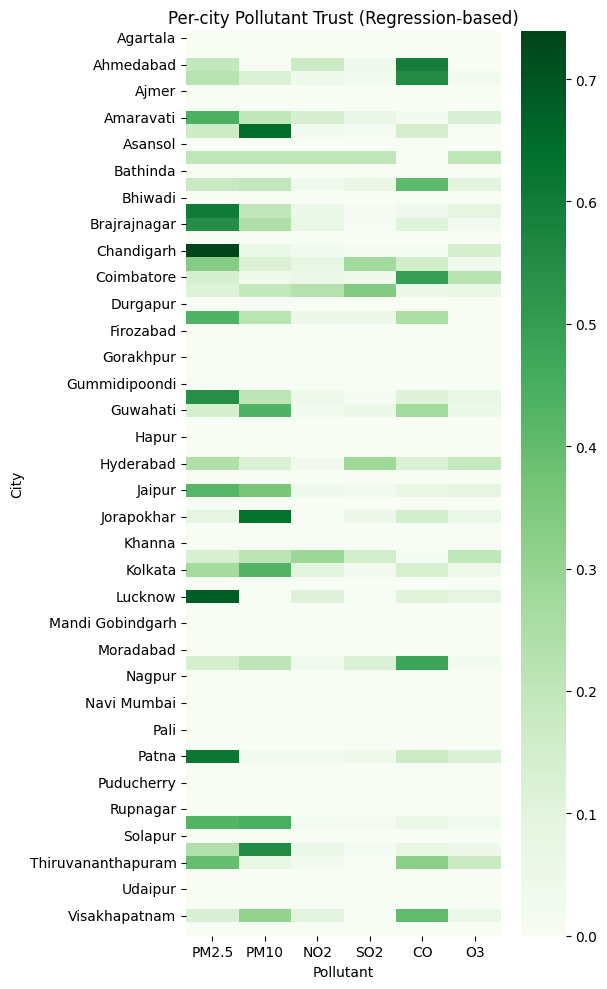

Saved: Regression_Trust_Heatmap.png


In [ ]:
# Regression-based trust weights per city
df_reg_in = pd.read_csv(DATA_PATH)
city_col_candidates = [c for c in df_reg_in.columns if any(x in c.lower() for x in ['city','location','place','station'])]
aqi_col_candidates = [c for c in df_reg_in.columns if 'aqi' in c.lower()]
if len(city_col_candidates) == 0:
    raise ValueError("No city/location column found! Check your column names.")
if len(aqi_col_candidates) == 0:
    raise ValueError("No AQI column found! Check your column names.")

city_col = city_col_candidates[0]
aqi_col = aqi_col_candidates[0]
poll_cols = [c for c in df_reg_in.columns if any(p in c.lower() for p in ['pm2','pm10','no2','so2','co','o3'])]

for c in [aqi_col] + poll_cols:
    df_reg_in[c] = pd.to_numeric(df_reg_in[c], errors='coerce')
cities = sorted(df_reg_in[city_col].dropna().unique())
trust_reg = pd.DataFrame(index=cities, columns=poll_cols, dtype=float)
for city in cities:
    d = df_reg_in[df_reg_in[city_col] == city].dropna(subset=[aqi_col] + poll_cols)
    if len(d) < 30:
        continue
    X = d[poll_cols].values
    y = d[aqi_col].values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    model = LinearRegression().fit(Xs, y)
    coefs = np.abs(model.coef_)
    coefs_norm = coefs / coefs.sum() if coefs.sum() > 0 else np.zeros_like(coefs)
    trust_reg.loc[city, :] = coefs_norm
trust_reg.fillna(0, inplace=True)
trust_reg.to_csv("trust_regression_per_city.csv")
print("Saved regression trust weights to 'trust_regression_per_city.csv'")
plt.figure(figsize=(6, 10))
sns.heatmap(trust_reg, cmap="Greens", annot=False)
plt.title("Per-city Pollutant Trust (Regression-based)")
plt.xlabel("Pollutant")
plt.ylabel("City")
plt.tight_layout()
plt.savefig("Regression_Trust_Heatmap.png", dpi=300)
plt.show()
print("Saved: Regression_Trust_Heatmap.png")

/tmp/ipython-input-785958580.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = sub2[polls].fillna(method='ffill').fillna(method='bfill').values
/tmp/ipython-input-785958580.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = sub2[polls].fillna(method='ffill').fillna(method='bfill').values
/tmp/ipython-input-785958580.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = sub2[polls].fillna(method='ffill').fillna(method='bfill').values
/tmp/ipython-input-785958580.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = sub2[polls].fillna(method='ffill').fillna(method='bfill').values
/tmp/ipython-input-785958580

Saved trust_mi_per_city.csv; shape: (68, 6)
              PM2.5      PM10       NO2       SO2        CO        O3
Agartala   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
Agra       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
Ahmedabad  0.115172  0.059638  0.180366  0.111896  0.455767  0.077161
Aizawl     0.317105  0.278029  0.039198  0.145386  0.147945  0.072337
Ajmer      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000


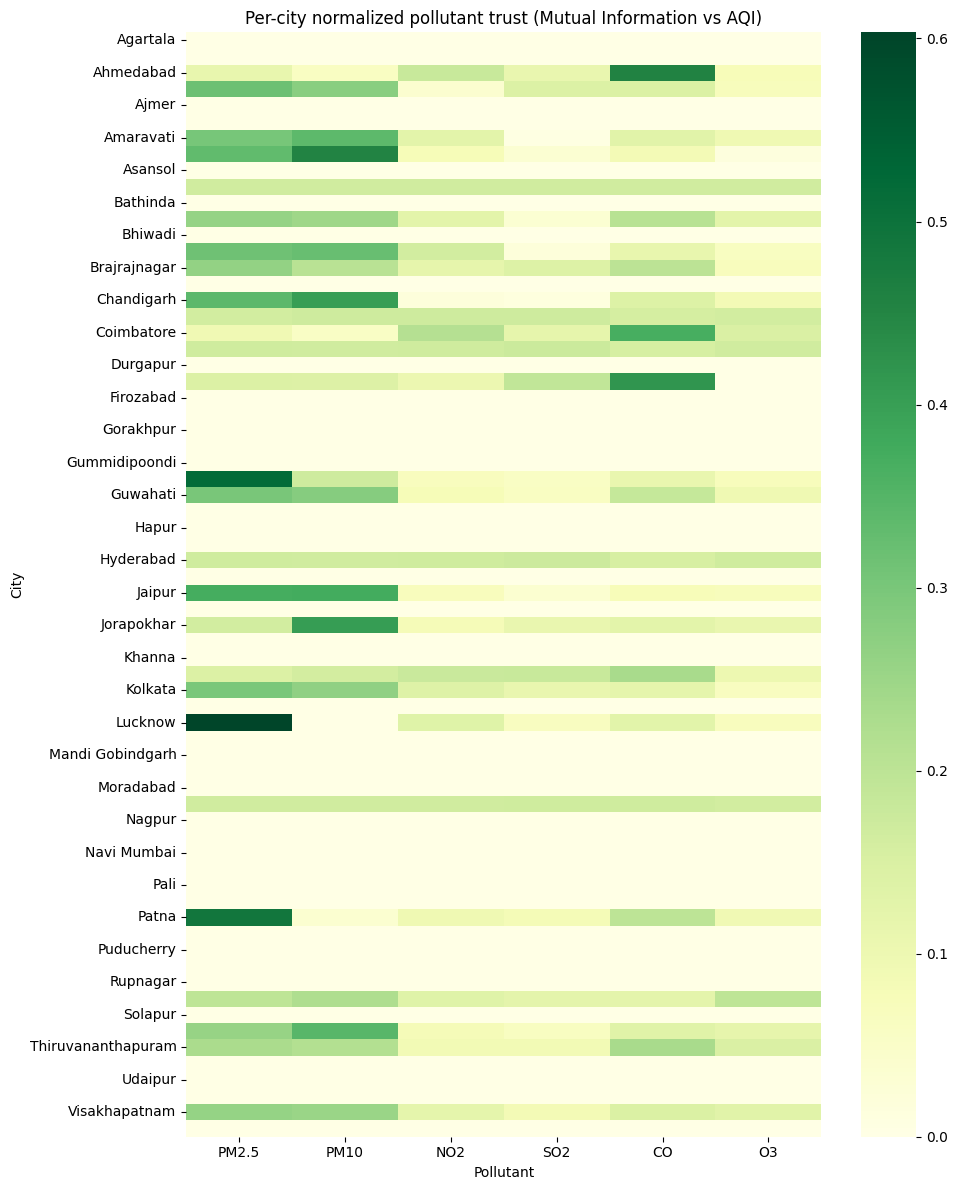

Saved: trust_mi_heatmap.png


In [ ]:
# Mutual Information based trust weights per city
df_mi_in = pd.read_csv(DATA_PATH)
if "City" not in df_mi_in.columns:
    # assume already normalized earlier; if not, adapt city column
    df_mi_in = df
if "AQI_kf" in df_mi_in.columns:
    aqi_col = "AQI_kf"
elif "AQI" in df_mi_in.columns:
    aqi_col = "AQI"
else:
    raise ValueError("No AQI column found. Add 'AQI' or 'AQI_kf' to dataframe.")
polls = [c for c in ["PM2.5","PM10","NO2","SO2","CO","O3"] if c in df_mi_in.columns]
if len(polls) == 0:
    raise ValueError("No pollutant columns found among expected names:", ["PM2.5","PM10","NO2","SO2","CO","O3"])
for c in [aqi_col] + polls:
    df_mi_in[c] = pd.to_numeric(df_mi_in[c], errors='coerce')
cities = sorted(df_mi_in["City"].dropna().unique())
min_samples = 30
trust_mi = pd.DataFrame(index=cities, columns=polls, dtype=float).fillna(0.0)

for city in cities:
    sub = df_mi_in[df_mi_in["City"] == city].copy()
    sub = sub.dropna(subset=[aqi_col])
    if len(sub) < min_samples:
        continue
    sub2 = sub.dropna(subset=polls, how='all')
    if len(sub2) < min_samples:
        continue
    X = sub2[polls].fillna(method='ffill').fillna(method='bfill').values
    y = sub2[aqi_col].values
    if np.nanstd(y) == 0:
        continue
    try:
        mi_vals = mutual_info_regression(X, y, discrete_features=False, random_state=0)
        mi_vals = np.maximum(mi_vals, 0.0)
    except Exception as e:
        print(f"MI error for {city}: {e}")
        continue
    if mi_vals.sum() > 0:
        trust_mi.loc[city, polls] = mi_vals / mi_vals.sum()
    else:
        trust_mi.loc[city, polls] = 0.0

trust_mi.to_csv("trust_mi_per_city.csv")
print("Saved trust_mi_per_city.csv; shape:", trust_mi.shape)
print(trust_mi.head())
plt.figure(figsize=(10, 12))
sns.heatmap(trust_mi.fillna(0.0), cmap="YlGn", annot=False)
plt.title("Per-city normalized pollutant trust (Mutual Information vs AQI)")
plt.xlabel("Pollutant")
plt.ylabel("City")
plt.tight_layout()
plt.savefig("trust_mi_heatmap.png", dpi=300)
plt.show()
print("Saved: trust_mi_heatmap.png")

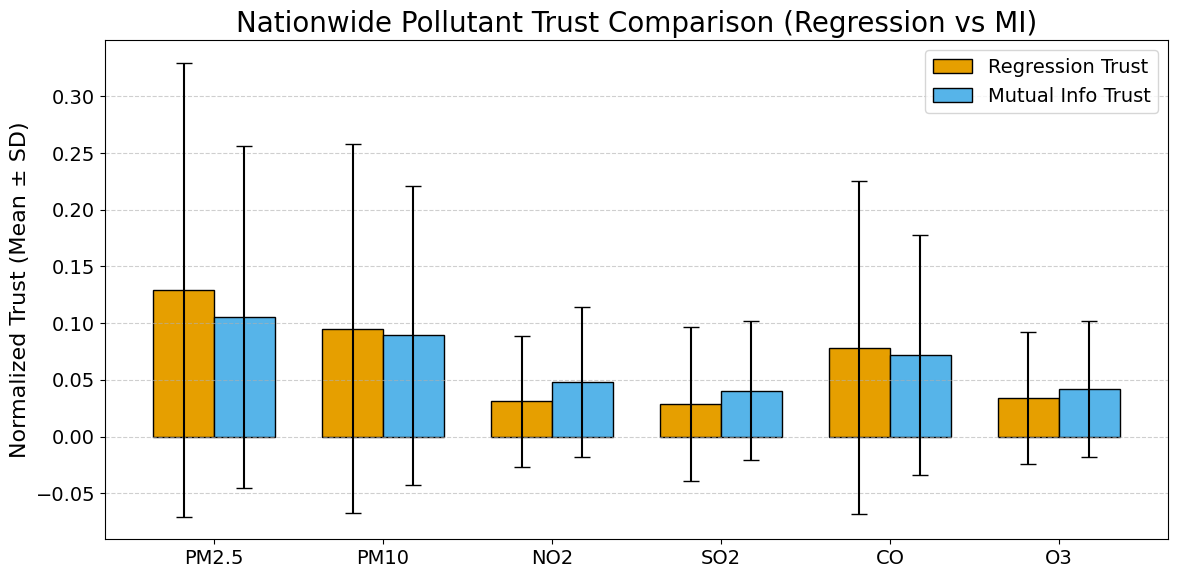

Saved: /content/India_AQI_workdir/results_citywise/Nationwide_Trust_Comparison_reg_vs_mi.png


In [ ]:
# Nationwide comparison Regression vs MI
RESULTS_DIR = "/content/India_AQI_workdir/results_citywise"
os.makedirs(RESULTS_DIR, exist_ok=True)
reg_path = "trust_regression_per_city.csv"
mi_path  = "trust_mi_per_city.csv"
df_reg = pd.read_csv(reg_path, index_col=0) if os.path.exists(reg_path) else None
df_mi  = pd.read_csv(mi_path, index_col=0)  if os.path.exists(mi_path) else None
polls = ["PM2.5","PM10","NO2","SO2","CO","O3"]
def mean_std_from(df, polls):
    means, stds = [], []
    for p in polls:
        if df is None or p not in df.columns:
            means.append(np.nan); stds.append(np.nan)
        else:
            col = pd.to_numeric(df[p], errors='coerce').dropna()
            means.append(col.mean() if len(col)>0 else np.nan)
            stds.append(col.std(ddof=0) if len(col)>0 else np.nan)
    return np.array(means), np.array(stds)
reg_mean, reg_std = mean_std_from(df_reg, polls)
mi_mean,  mi_std  = mean_std_from(df_mi, polls)
plt.rcParams.update({
    "figure.figsize": (12,6),
    "font.size": 14,
    "axes.titlesize": 20,
    "axes.labelsize": 16
})
x = np.arange(len(polls))
width = 0.36
fig, ax = plt.subplots()
ax.bar(x - width/2, reg_mean, width, yerr=reg_std,
       label='Regression Trust',
       color='#E69F00', edgecolor='k', capsize=6)
ax.bar(x + width/2, mi_mean,  width, yerr=mi_std,
       label='Mutual Info Trust',
       color='#56B4E9', edgecolor='k', capsize=6)
ax.set_xticks(x)
ax.set_xticklabels(polls)
ax.set_ylabel("Normalized Trust (Mean ± SD)")
ax.set_title("Nationwide Pollutant Trust Comparison (Regression vs MI)")
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
out = os.path.join(RESULTS_DIR, "Nationwide_Trust_Comparison_reg_vs_mi.png")
plt.savefig(out, dpi=600, bbox_inches='tight')
plt.show()
print("Saved:", out)

In [ ]:
# Cell F3: NSGA-II optimizer for sensor weights
import numpy as np
import pandas as pd
import glob, os
from tqdm import tqdm
RESULTS_DIR = "/content/India_AQI_workdir/results_citywise"  # keep same as before
os.makedirs(RESULTS_DIR, exist_ok=True)
def nsga2_optimize_weights(
    X,
    y_ref,
    pop_size=60,
    n_gen=60,
    crossover_prob=0.9,
    mutation_prob=0.2,
    eta_mut=0.2,
    sparsity_eps=1e-3,
    seed=42
):
    """
    NSGA-II for multi-objective optimization of sensor weights.
    Objectives:
      f1 = RMSE(Xw, y_ref)  (minimize)
      f2 = fraction of active sensors (sparsity)  (minimize)
    X: (n_samples, n_sensors)
    y_ref: (n_samples,)
    Returns:
      best_w_rmse: weight vector with minimum RMSE among final Pareto front
      pareto_w: 2D array of Pareto weights (K x n_sensors)
      pareto_f: 2D array of Pareto fitnesses (K x 2) [RMSE, sparsity]
    """
    rng = np.random.default_rng(seed)
    X = np.asarray(X, float)
    y_ref = np.asarray(y_ref, float)
    mask_valid = ~np.isnan(y_ref) & ~np.isnan(X).all(axis=1)
    if mask_valid.sum() < 10:
        raise ValueError("Not enough valid samples for NSGA-II optimization")
    Xv = X[mask_valid]
    yv = y_ref[mask_valid]
    n_sensors = Xv.shape[1]

    def evaluate(w):
        """Return two-objective fitness: [RMSE, sparsity] to minimize."""
        w = np.clip(w, 0, None)
        s = w.sum()
        if s <= 0:
            w = np.ones_like(w) / len(w)
        else:
            w = w / s
        pred = Xv.dot(w)
        rmse_val = np.sqrt(np.mean((yv - pred) ** 2))
        sparsity = (w > sparsity_eps).mean()  # fraction of active sensors
        return np.array([rmse_val, sparsity], dtype=float), w

    # NSGA-II machinery
    def fast_non_dominated_sort(F):
        """
        F: (N, M) fitness array
        Returns list of fronts, each a list of indices into population.
        """
        N = F.shape[0]
        S = [set() for _ in range(N)]
        n = np.zeros(N, dtype=int)
        fronts = [[]]
        for p in range(N):
            for q in range(N):
                if p == q:
                    continue
                # p dominates q if p <= q for all and < for at least one
                if np.all(F[p] <= F[q]) and np.any(F[p] < F[q]):
                    S[p].add(q)
                elif np.all(F[q] <= F[p]) and np.any(F[q] < F[p]):
                    n[p] += 1
            if n[p] == 0:
                fronts[0].append(p)
        i = 0
        while fronts[i]:
            Q = []
            for p in fronts[i]:
                for q in S[p]:
                    n[q] -= 1
                    if n[q] == 0:
                        Q.append(q)
            i += 1
            fronts.append(Q)
        if not fronts[-1]:
            fronts.pop()
        return fronts
    def crowding_distance(F, front):
        """
        F: (N, M) fitness
        front: list of indices
        Returns crowding distance array (len(front),)
        """
        if len(front) == 0:
            return np.array([])
        M = F.shape[1]
        distances = np.zeros(len(front))
        front_idx = np.array(front)
        F_front = F[front_idx]

        for m in range(M):
            order = np.argsort(F_front[:, m])
            sorted_idx = front_idx[order]
            f_min = F_front[order[0], m]
            f_max = F_front[order[-1], m]
            distances[order[0]] = np.inf
            distances[order[-1]] = np.inf
            if f_max > f_min:
                for i in range(1, len(front) - 1):
                    prev_f = F_front[order[i - 1], m]
                    next_f = F_front[order[i + 1], m]
                    distances[order[i]] += (next_f - prev_f) / (f_max - f_min)
        return distances
    def tournament_select(pop, F, ranks, crowding, k=2):
        """
        Binary tournament selection based on rank, then crowding.
        Returns index into pop.
        """
        N = len(pop)
        candidates = rng.integers(0, N, size=k)
        best = candidates[0]
        for c in candidates[1:]:
            if ranks[c] < ranks[best]:
                best = c
            elif ranks[c] == ranks[best] and crowding[c] > crowding[best]:
                best = c
        return best
    # Initialize population (on simplex)
    pop = rng.random((pop_size, n_sensors))
    pop = pop / (pop.sum(axis=1, keepdims=True) + 1e-9)
    F = np.zeros((pop_size, 2), dtype=float)

    for i in range(pop_size):
        fit_i, w_corr = evaluate(pop[i])
        F[i] = fit_i
        pop[i] = w_corr

    # Evolution
    for _ in range(n_gen):
        # Non-dominated sorting
        fronts = fast_non_dominated_sort(F)
        ranks = np.empty(pop_size, dtype=int)
        for r, front in enumerate(fronts):
            for idx in front:
                ranks[idx] = r

        # Crowding distances
        crowd = np.zeros(pop_size)
        for front in fronts:
            cd = crowding_distance(F, front)
            for j, idx in enumerate(front):
                crowd[idx] = cd[j]

        # Generate offspring via tournament + crossover + mutation
        offspring = []
        while len(offspring) < pop_size:
            p1_idx = tournament_select(pop, F, ranks, crowd)
            p2_idx = tournament_select(pop, F, ranks, crowd)
            p1 = pop[p1_idx].copy()
            p2 = pop[p2_idx].copy()

            # Crossover
            if rng.random() < crossover_prob:
                alpha = rng.random(n_sensors)
                child1 = alpha * p1 + (1 - alpha) * p2
                child2 = alpha * p2 + (1 - alpha) * p1
            else:
                child1, child2 = p1, p2

            # Mutation
            for child in (child1, child2):
                if rng.random() < mutation_prob:
                    noise = rng.normal(0, eta_mut, size=n_sensors)
                    child += noise
                child = np.clip(child, 0, None)
                s = child.sum()
                child = child / s if s > 0 else np.ones_like(child) / n_sensors
                offspring.append(child)
                if len(offspring) >= pop_size:
                    break

        offspring = np.array(offspring)
        F_off = np.zeros_like(F)
        for i in range(pop_size):
            fit_i, w_corr = evaluate(offspring[i])
            F_off[i] = fit_i
            offspring[i] = w_corr

        # Combine and select next generation
        combined_pop = np.vstack([pop, offspring])
        combined_F = np.vstack([F, F_off])
        N_combined = combined_pop.shape[0]
        fronts = fast_non_dominated_sort(combined_F)

        new_pop = []
        new_F = []
        for front in fronts:
            if len(new_pop) + len(front) > pop_size:
                # need partial fill from this front based on crowding distance
                cd = crowding_distance(combined_F, front)
                # sort front by crowding distance descending
                front_array = np.array(front)
                order = np.argsort(-cd)  # descending
                needed = pop_size - len(new_pop)
                chosen = front_array[order[:needed]]
                for idx in chosen:
                    new_pop.append(combined_pop[idx])
                    new_F.append(combined_F[idx])
                break
            else:
                for idx in front:
                    new_pop.append(combined_pop[idx])
                    new_F.append(combined_F[idx])

        pop = np.array(new_pop)
        F = np.array(new_F)

    # Final Pareto front & best solution by RMSE
    fronts = fast_non_dominated_sort(F)
    best_front_indices = fronts[0]
    pareto_w = pop[best_front_indices]
    pareto_f = F[best_front_indices]

    # choose solution on Pareto front with minimum RMSE (objective 0)
    best_idx_local = np.argmin(pareto_f[:, 0])
    best_w_rmse = pareto_w[best_idx_local]
    return best_w_rmse, pareto_w, pareto_f


# Apply NSGA-II for comparison (per city)
files_wrkf = sorted(glob.glob(os.path.join(RESULTS_DIR, "*_WRKF.csv")))
print("Found WRKF files for NSGA-II:", len(files_wrkf))
for f in tqdm(files_wrkf, desc="NSGA-II fusion per city"):
    dfc = pd.read_csv(f, parse_dates=["Date"])
    city = os.path.basename(f).replace("_WRKF.csv", "")
    # reference: prefer AQI_kf then AQI
    if "AQI_kf" in dfc.columns and not dfc["AQI_kf"].isna().all():
        y_ref = dfc["AQI_kf"].values
    elif "AQI" in dfc.columns and not dfc["AQI"].isna().all():
        y_ref = dfc["AQI"].values
    else:
        print(f"[NSGA-II] Skipping {city}: no AQI or AQI_kf reference.")
        continue

    sensor_cols = [c for c in ["PM2.5", "PM10", "NO2", "SO2", "CO", "O3"] if c in dfc.columns]
    if len(sensor_cols) < 2:
        print(f"[NSGA-II] Skipping {city}: not enough pollutant columns.")
        continue
    X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
    try:
        best_w_nsga, pareto_w, pareto_f = nsga2_optimize_weights(
            X,
            y_ref,
            pop_size=60,
            n_gen=60,
            crossover_prob=0.9,
            mutation_prob=0.2,
            eta_mut=0.05,
            sparsity_eps=1e-3,
            seed=SEED
        )
    except Exception as e:
        print(f"[NSGA-II] Failed for {city}:", e)
        continue
    fused_nsga2 = X.dot(best_w_nsga)
    dfc_nsga = dfc.copy()
    dfc_nsga["fused_NSGA2"] = fused_nsga2
    outp = os.path.join(RESULTS_DIR, f"{city}_NSGA2.csv")
    dfc_nsga.to_csv(outp, index=False)
    # Save Pareto front for later analysis
    np.save(os.path.join(RESULTS_DIR, f"{city}_NSGA2_pareto_weights.npy"), pareto_w)
    np.save(os.path.join(RESULTS_DIR, f"{city}_NSGA2_pareto_fitness.npy"), pareto_f)
    print(f"[NSGA-II] {city}: best RMSE={pareto_f[np.argmin(pareto_f[:,0]),0]:.3f}, "
          f"best sparsity={pareto_f[np.argmin(pareto_f[:,0]),1]:.3f}")
print("NSGA-II comparison complete. *_NSGA2.csv files written to", RESULTS_DIR)

Found WRKF files for NSGA-II: 27


NSGA-II fusion per city:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:   4%|▎         | 1/27 [00:18<08:11, 18.90s/it]

[NSGA-II] Ahmedabad: best RMSE=326.052, best sparsity=0.167


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:   7%|▋         | 2/27 [00:36<07:33, 18.13s/it]

[NSGA-II] Aizawl: best RMSE=21.505, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  11%|█         | 3/27 [00:53<06:58, 17.45s/it]

[NSGA-II] Amaravati: best RMSE=44.127, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  15%|█▍        | 4/27 [01:08<06:22, 16.62s/it]

[NSGA-II] Amritsar: best RMSE=58.464, best sparsity=0.500


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  19%|█▊        | 5/27 [01:29<06:42, 18.31s/it]

[NSGA-II] Bangalore: best RMSE=24.038, best sparsity=1.000


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  22%|██▏       | 6/27 [01:45<06:05, 17.40s/it]

[NSGA-II] Bengaluru: best RMSE=35.517, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  26%|██▌       | 7/27 [02:01<05:41, 17.06s/it]

[NSGA-II] Bhopal: best RMSE=49.918, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  30%|██▉       | 8/27 [02:17<05:16, 16.68s/it]

[NSGA-II] Brajrajnagar: best RMSE=70.803, best sparsity=0.500


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  33%|███▎      | 9/27 [02:34<05:03, 16.89s/it]

[NSGA-II] Chandigarh: best RMSE=40.172, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  37%|███▋      | 10/27 [02:52<04:48, 16.99s/it]

[NSGA-II] Chennai: best RMSE=29.080, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  41%|████      | 11/27 [03:08<04:26, 16.66s/it]

[NSGA-II] Coimbatore: best RMSE=38.631, best sparsity=0.167


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  44%|████▍     | 12/27 [03:23<04:03, 16.21s/it]

[NSGA-II] Delhi: best RMSE=102.878, best sparsity=0.667


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  48%|████▊     | 13/27 [03:39<03:48, 16.34s/it]

[NSGA-II] Ernakulam: best RMSE=35.614, best sparsity=0.500


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  52%|█████▏    | 14/27 [03:56<03:33, 16.39s/it]

[NSGA-II] Gurugram: best RMSE=72.539, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  56%|█████▌    | 15/27 [04:12<03:14, 16.18s/it]

[NSGA-II] Guwahati: best RMSE=86.168, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  59%|█████▉    | 16/27 [04:27<02:55, 15.99s/it]

[NSGA-II] Hyderabad: best RMSE=34.027, best sparsity=0.500


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  63%|██████▎   | 17/27 [04:44<02:41, 16.18s/it]

[NSGA-II] Jaipur: best RMSE=51.080, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  67%|██████▋   | 18/27 [05:02<02:30, 16.75s/it]

[NSGA-II] Jorapokhar: best RMSE=67.927, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  70%|███████   | 19/27 [05:19<02:14, 16.85s/it]

[NSGA-II] Kochi: best RMSE=59.369, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  74%|███████▍  | 20/27 [05:35<01:56, 16.62s/it]

[NSGA-II] Kolkata: best RMSE=74.983, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  78%|███████▊  | 21/27 [05:53<01:41, 16.92s/it]

[NSGA-II] Lucknow: best RMSE=106.118, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  81%|████████▏ | 22/27 [06:09<01:22, 16.59s/it]

[NSGA-II] Mumbai: best RMSE=32.549, best sparsity=0.667


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  85%|████████▌ | 23/27 [06:25<01:06, 16.63s/it]

[NSGA-II] Patna: best RMSE=95.480, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  89%|████████▉ | 24/27 [06:41<00:49, 16.34s/it]

[NSGA-II] Shillong: best RMSE=23.761, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  93%|█████████▎| 25/27 [06:58<00:33, 16.69s/it]

[NSGA-II] Talcher: best RMSE=92.379, best sparsity=0.333


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city:  96%|█████████▋| 26/27 [07:15<00:16, 16.70s/it]

[NSGA-II] Thiruvananthapuram: best RMSE=31.610, best sparsity=0.167


/tmp/ipython-input-3042838119.py:249: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
NSGA-II fusion per city: 100%|██████████| 27/27 [07:31<00:00, 16.70s/it]

[NSGA-II] Visakhapatnam: best RMSE=37.441, best sparsity=0.500
NSGA-II comparison complete. *_NSGA2.csv files written to /content/India_AQI_workdir/results_citywise


In [ ]:
# Cell F4: Simulated Annealing optimizer for sensor weights
import numpy as np
import pandas as pd
import glob, os
from tqdm import tqdm
RESULTS_DIR = "/content/India_AQI_workdir/results_citywise"  # same as before
os.makedirs(RESULTS_DIR, exist_ok=True)
def sa_optimize_weights(
    X,
    y_ref,
    max_iter=800,
    T_start=1.0,
    T_end=1e-3,
    step_scale=0.05,
    seed=42
):
    """
    Simulated Annealing to optimize sensor reliability weights.
    Single-objective: minimize RMSE(Xw, y_ref).

    X: (n_samples, n_sensors)
    y_ref: (n_samples,)
    Returns:
        best_w: best weight vector (sum=1, non-negative)
        hist: list of (iter, temp, f_best) for diagnostics (optional)
    """
    rng = np.random.default_rng(seed)

    X = np.asarray(X, float)
    y_ref = np.asarray(y_ref, float)
    mask_valid = ~np.isnan(y_ref) & ~np.isnan(X).all(axis=1)
    if mask_valid.sum() < 10:
        raise ValueError("Not enough valid samples for SA optimization")

    Xv = X[mask_valid]
    yv = y_ref[mask_valid]
    n_sensors = Xv.shape[1]

    def fitness(w):
        """RMSE between fused and reference (single objective)."""
        w = np.clip(w, 0, None)
        s = w.sum()
        if s <= 0:
            w = np.ones_like(w) / len(w)
        else:
            w = w / s
        pred = Xv.dot(w)
        return float(np.sqrt(np.mean((yv - pred) ** 2)))

    # initialization on simplex
    w_curr = rng.random(n_sensors)
    w_curr = w_curr / (w_curr.sum() + 1e-9)
    f_curr = fitness(w_curr)
    w_best = w_curr.copy()
    f_best = f_curr
    hist = []
    for it in range(max_iter):
        # temperature schedule (geometric cooling)
        t = it / max_iter
        T = T_start * (T_end / T_start) ** t

        # propose a new weight vector near current one
        noise = rng.normal(0, step_scale, size=n_sensors)
        w_prop = w_curr + noise
        w_prop = np.clip(w_prop, 0, None)
        s = w_prop.sum()
        if s <= 0:
            w_prop = np.ones_like(w_prop) / n_sensors
        else:
            w_prop = w_prop / s

        f_prop = fitness(w_prop)
        delta = f_prop - f_curr

        # accept if better, or with Boltzmann probability if worse
        if (delta <= 0) or (rng.random() < np.exp(-delta / (T + 1e-12))):
            w_curr = w_prop
            f_curr = f_prop

            # track global best
            if f_curr < f_best:
                f_best = f_curr
                w_best = w_curr.copy()
        if (it % 20) == 0 or it == max_iter - 1:
            hist.append((it, T, f_best))
    return w_best, hist

# Apply SA per city
files_wrkf = sorted(glob.glob(os.path.join(RESULTS_DIR, "*_WRKF.csv")))
print("Found WRKF files for SA:", len(files_wrkf))
for f in tqdm(files_wrkf, desc="SA fusion per city"):
    dfc = pd.read_csv(f, parse_dates=["Date"])
    city = os.path.basename(f).replace("_WRKF.csv", "")
    # reference: prefer AQI_kf then AQI
    if "AQI_kf" in dfc.columns and not dfc["AQI_kf"].isna().all():
        y_ref = dfc["AQI_kf"].values
    elif "AQI" in dfc.columns and not dfc["AQI"].isna().all():
        y_ref = dfc["AQI"].values
    else:
        print(f"[SA] Skipping {city}: no AQI or AQI_kf reference.")
        continue
    sensor_cols = [c for c in ["PM2.5", "PM10", "NO2", "SO2", "CO", "O3"] if c in dfc.columns]
    if len(sensor_cols) < 2:
        print(f"[SA] Skipping {city}: not enough pollutant columns.")
        continue
    X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
    try:
        best_w_sa, hist_sa = sa_optimize_weights(
            X,
            y_ref,
            max_iter=800,
            T_start=1.0,
            T_end=1e-3,
            step_scale=0.05,
            seed=SEED
        )
    except Exception as e:
        print(f"[SA] Failed for {city}:", e)
        continue
    fused_sa = X.dot(best_w_sa)
    dfc_sa = dfc.copy()
    dfc_sa["fused_SA"] = fused_sa
    outp = os.path.join(RESULTS_DIR, f"{city}_SA.csv")
    dfc_sa.to_csv(outp, index=False)
    # Save history (iteration, T, f_best) for plotting
    hist_sa_arr = np.array(hist_sa, dtype=float)
    np.save(os.path.join(RESULTS_DIR, f"{city}_SA_hist.npy"), hist_sa_arr)
    print(f"[SA] {city}: best RMSE approx = {hist_sa[-1][2]:.3f}")
print("Simulated Annealing comparison complete. *_SA.csv files written to", RESULTS_DIR)

Found WRKF files for SA: 27


SA fusion per city:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
SA fusion per city:   7%|▋         | 2/27 [00:00<00:01, 19.80it/s]

[SA] Ahmedabad: best RMSE approx = 326.052
[SA] Aizawl: best RMSE approx = 21.502
[SA] Amaravati: best RMSE approx = 44.128


/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
SA fusion per city:  15%|█▍        | 4/27 [00:00<00:01, 17.95it/s]

[SA] Amritsar: best RMSE approx = 58.463


/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
SA fusion per city:  22%|██▏       | 6/27 [00:00<00:01, 13.44it/s]

[SA] Bangalore: best RMSE approx = 24.038
[SA] Bengaluru: best RMSE approx = 35.498


/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
SA fusion per city:  30%|██▉       | 8/27 [00:00<00:01, 15.37it/s]

[SA] Bhopal: best RMSE approx = 49.918
[SA] Brajrajnagar: best RMSE approx = 70.803


/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)


[SA] Chandigarh: best RMSE approx = 40.172


SA fusion per city:  37%|███▋      | 10/27 [00:00<00:01, 13.82it/s]/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)


[SA] Chennai: best RMSE approx = 29.080
[SA] Coimbatore: best RMSE approx = 38.631


/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
SA fusion per city:  44%|████▍     | 12/27 [00:00<00:01, 13.30it/s]

[SA] Delhi: best RMSE approx = 102.867


/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
SA fusion per city:  52%|█████▏    | 14/27 [00:00<00:00, 14.45it/s]

[SA] Ernakulam: best RMSE approx = 33.943
[SA] Gurugram: best RMSE approx = 72.540
[SA] Guwahati: best RMSE approx = 86.166


/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
SA fusion per city:  59%|█████▉    | 16/27 [00:01<00:00, 13.61it/s]/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj

[SA] Hyderabad: best RMSE approx = 34.021
[SA] Jaipur: best RMSE approx = 51.081
[SA] Jorapokhar: best RMSE approx = 67.927
[SA] Kochi: best RMSE approx = 59.349


/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
SA fusion per city:  74%|███████▍  | 20/27 [00:01<00:00, 15.01it/s]/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj

[SA] Kolkata: best RMSE approx = 74.983
[SA] Lucknow: best RMSE approx = 104.893
[SA] Mumbai: best RMSE approx = 32.541


/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
SA fusion per city:  89%|████████▉ | 24/27 [00:01<00:00, 14.08it/s]/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj

[SA] Patna: best RMSE approx = 95.144
[SA] Shillong: best RMSE approx = 23.760
[SA] Talcher: best RMSE approx = 92.379
[SA] Thiruvananthapuram: best RMSE approx = 31.610


/tmp/ipython-input-3987649398.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = dfc[sensor_cols].fillna(method="ffill").fillna(method="bfill").values.astype(float)
SA fusion per city: 100%|██████████| 27/27 [00:01<00:00, 14.44it/s]

[SA] Visakhapatnam: best RMSE approx = 37.445
Simulated Annealing comparison complete. *_SA.csv files written to /content/India_AQI_workdir/results_citywise


In [ ]:
# Cell: Compare all models (WR, WRKF, GA–PSO, NSGA-II, SA)
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
RESULTS_DIR = "/content/India_AQI_workdir/results_citywise"
FIG_DIR = os.path.join(RESULTS_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)
def safe_rmse(a, b):
    a, b = np.array(a), np.array(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    if mask.sum() < 2:
        return np.nan
    return float(np.sqrt(mean_squared_error(a[mask], b[mask])))

def safe_mae(a, b):
    a, b = np.array(a), np.array(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    if mask.sum() < 2:
        return np.nan
    return float(mean_absolute_error(a[mask], b[mask]))

def safe_bias(a, b):
    a, b = np.array(a), np.array(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    if mask.sum() < 2:
        return np.nan
    return float(np.mean(b[mask] - a[mask]))

def safe_corr(a, b):
    a, b = np.array(a), np.array(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    if mask.sum() < 2:
        return np.nan
    return float(np.corrcoef(a[mask], b[mask])[0, 1])

# Define models: (label, suffix, fused_column_name)
MODEL_SPECS = [
    ("WR",      "_WR.csv",    "fused_WR"),
    ("WRKF",    "_WRKF.csv",  "fused_KF"),
    ("GA-PSO",  "_Best.csv",  "fused_best"),
    ("NSGA-II", "_NSGA2.csv", "fused_NSGA2"),
    ("SA",      "_SA.csv",    "fused_SA"),
]
rows = []
# For each model, scan its files and compute metrics per city
for model_name, suffix, fused_col in MODEL_SPECS:
    pattern = os.path.join(RESULTS_DIR, f"*{suffix}")
    files = sorted(glob.glob(pattern))
    if not files:
        print(f"[INFO] No files found for model {model_name} with pattern {pattern}")
        continue

    print(f"[INFO] Processing {len(files)} files for model {model_name} ...")

    for f in files:
        base = os.path.basename(f)
        # recover city name before suffix
        city = base.replace(suffix, "")

        try:
            df = pd.read_csv(f, parse_dates=["Date"])
        except Exception:
            df = pd.read_csv(f)

        # choose reference: prefer AQI_kf, then AQI
        if "AQI_kf" in df.columns and not df["AQI_kf"].isna().all():
            ref_col = "AQI_kf"
        elif "AQI" in df.columns and not df["AQI"].isna().all():
            ref_col = "AQI"
        else:
            ref_col = None

        if ref_col is None:
            rows.append({
                "City": city,
                "Model": model_name,
                "Ref": "none",
                "RMSE": np.nan,
                "MAE": np.nan,
                "Bias": np.nan,
                "Corr": np.nan,
                "n_valid": 0
            })
            continue

        if fused_col not in df.columns:
            rows.append({
                "City": city,
                "Model": model_name,
                "Ref": ref_col,
                "RMSE": np.nan,
                "MAE": np.nan,
                "Bias": np.nan,
                "Corr": np.nan,
                "n_valid": 0
            })
            continue
        ref = df[ref_col].values
        fused = df[fused_col].values
        mask = ~np.isnan(ref) & ~np.isnan(fused)
        n_valid = int(mask.sum())
        if n_valid < 2:
            rows.append({
                "City": city,
                "Model": model_name,
                "Ref": ref_col,
                "RMSE": np.nan,
                "MAE": np.nan,
                "Bias": np.nan,
                "Corr": np.nan,
                "n_valid": n_valid
            })
            continue
        r  = safe_rmse(ref, fused)
        m  = safe_mae(ref, fused)
        b  = safe_bias(ref, fused)
        cc = safe_corr(ref, fused)
        rows.append({
            "City": city,
            "Model": model_name,
            "Ref": ref_col,
            "RMSE": r,
            "MAE": m,
            "Bias": b,
            "Corr": cc,
            "n_valid": n_valid
        })
# Build summary dataframe
df_all = pd.DataFrame(rows)
summary_all_path = os.path.join(RESULTS_DIR, "summary_metrics_all_models.csv")
df_all.to_csv(summary_all_path, index=False)
print("Saved unified metrics to:", summary_all_path)
display(df_all.head())
# RMSE boxplot across models (optional visual)
df_plot = df_all.copy()
df_plot = df_plot.dropna(subset=["RMSE"])
if df_plot.empty:
    print("No valid RMSE values found to plot.")
else:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df_plot, x="Model", y="RMSE")
    plt.title("RMSE by Model Across Cities")
    plt.ylabel("RMSE vs Reference AQI")
    plt.xlabel("Model")
    plt.tight_layout()
    out = os.path.join(FIG_DIR, "rmse_boxplot_all_models.png")
    plt.savefig(out, dpi=300)
    plt.close()
    print("Saved:", out)
# Which model is best per city (by RMSE)
df_best = df_all.dropna(subset=["RMSE"]).copy()
if df_best.empty:
    print("No valid RMSE values to determine winners.")
else:
    idx = df_best.groupby("City")["RMSE"].idxmin()
    df_winners = df_best.loc[idx]
    print("Per-city best model counts (by RMSE):")
    print(df_winners["Model"].value_counts())
    plt.figure(figsize=(6, 4))
    df_winners["Model"].value_counts().plot(kind="bar")
    plt.ylabel("Number of Cities (lowest RMSE)")
    plt.title("Model Winning Count Across Cities")
    plt.xticks(rotation=45)
    plt.tight_layout()
    out = os.path.join(FIG_DIR, "model_win_count_bar.png")
    plt.savefig(out, dpi=300)
    plt.close()
    print("Saved:", out)
# Display full numeric metric comparisons (no plots, primary evaluation)
summary_file = summary_all_path  # same file we just wrote
if not os.path.exists(summary_file):
    raise FileNotFoundError(
        "summary_metrics_all_models.csv not found. Run the unified comparison part above first."
    )
df_all_loaded = pd.read_csv(summary_file)
print("\n🔹 Full metrics dataset shape:", df_all_loaded.shape)
print("Columns:", df_all_loaded.columns.tolist(), "\n")
# Show first few rows
display(df_all_loaded.head(10))
# Best model per city (lowest RMSE)
df_valid = df_all_loaded.dropna(subset=["RMSE"]).copy()
idx = df_valid.groupby("City")["RMSE"].idxmin()
df_winners = df_valid.loc[idx][["City", "Model", "RMSE"]].sort_values("City")
print("\n Best model per City (by RMSE):\n")
display(df_winners.reset_index(drop=True))
# Average performance by model
df_stats = df_valid.groupby("Model").agg({
    "RMSE": ["mean", "std"],
    "MAE": ["mean", "std"],
    "Bias": "mean",
    "Corr": ["mean", "std"]
})
print("\n Model-wise Performance Summary (averaged across cities):\n")
display(df_stats)
# Count wins per model
win_counts = df_winners["Model"].value_counts()
print("\n Model Win Counts (lowest RMSE per city):\n")
print(win_counts.to_string())

[INFO] Processing 27 files for model WR ...
[INFO] Processing 27 files for model WRKF ...
[INFO] Processing 27 files for model GA-PSO ...
[INFO] Processing 27 files for model NSGA-II ...
[INFO] Processing 27 files for model SA ...
Saved unified metrics to: /content/India_AQI_workdir/results_citywise/summary_metrics_all_models.csv


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,City,Model,Ref,RMSE,MAE,Bias,Corr,n_valid
0,Ahmedabad,WR,AQI_kf,385.112029,384.415436,-384.415436,0.454993,1412
1,Aizawl,WR,AQI_kf,32.467665,32.372739,-32.372739,0.714560,114
2,Amaravati,WR,AQI_kf,67.877685,66.300086,-66.300086,0.344968,897
3,Amritsar,WR,AQI_kf,98.518888,98.233419,-98.233419,0.147920,1195
4,Bangalore,WR,AQI_kf,24.463648,20.879202,-12.157813,0.251876,2552


Saved: /content/India_AQI_workdir/results_citywise/figures/rmse_boxplot_all_models.png
Per-city best model counts (by RMSE):
Model
GA-PSO     17
SA          5
NSGA-II     4
WRKF        1
Name: count, dtype: int64
Saved: /content/India_AQI_workdir/results_citywise/figures/model_win_count_bar.png

🔹 Full metrics dataset shape: (135, 8)
Columns: ['City', 'Model', 'Ref', 'RMSE', 'MAE', 'Bias', 'Corr', 'n_valid'] 



,City,Model,Ref,RMSE,MAE,Bias,Corr,n_valid
0,Ahmedabad,WR,AQI_kf,385.112029,384.415436,-384.415436,0.454993,1412
1,Aizawl,WR,AQI_kf,32.467665,32.372739,-32.372739,0.714560,114
2,Amaravati,WR,AQI_kf,67.877685,66.300086,-66.300086,0.344968,897
3,Amritsar,WR,AQI_kf,98.518888,98.233419,-98.233419,0.147920,1195
4,Bangalore,WR,AQI_kf,24.463648,20.879202,-12.157813,0.251876,2552
5,Bengaluru,WR,AQI_kf,66.981187,66.128851,-66.128125,-0.006146,2007
6,Bhopal,WR,AQI_kf,96.412703,95.193140,-95.193140,0.716401,280
7,Brajrajnagar,WR,AQI_kf,132.766893,132.617366,-132.617366,0.270100,795
8,Chandigarh,WR,AQI_kf,81.792206,81.736774,-81.736774,0.139353,304
9,Chennai,WR,AQI_kf,48.760088,41.395683,-35.230681,-0.414020,3630



 Best model per City (by RMSE):



,City,Model,RMSE
0,Ahmedabad,NSGA-II,326.051602
1,Aizawl,GA-PSO,21.501611
2,Amaravati,GA-PSO,44.127489
3,Amritsar,GA-PSO,58.463128
4,Bangalore,WRKF,21.350298
5,Bengaluru,GA-PSO,35.498300
6,Bhopal,GA-PSO,49.917525
7,Brajrajnagar,GA-PSO,70.802039
8,Chandigarh,GA-PSO,40.172000
9,Chennai,GA-PSO,29.079770



 Model-wise Performance Summary (averaged across cities):



RMSE                    MAE                  Bias      Corr  \
               mean        std        mean        std       mean      mean   
Model                                                                        
GA-PSO    64.426971  58.175321   57.568150  58.683093 -45.983979  0.289472   
NSGA-II   64.527014  58.182779   57.735287  58.676446 -46.215682  0.301896   
SA        64.404780  58.175926   57.663543  58.679472 -46.167635  0.300594   
WR       102.136134  72.945829  100.138518  73.542869 -96.946281  0.168178   
WRKF     101.477278  73.258379   99.612013  73.854686 -96.925787  0.186196   

                   
              std  
Model              
GA-PSO   0.236706  
NSGA-II  0.225511  
SA       0.233599  
WR       0.331126  
WRKF     0.361860


 Model Win Counts (lowest RMSE per city):

Model
GA-PSO     17
SA          5
NSGA-II     4
WRKF        1


In [ ]:
# Cell: NSGA-II Pareto front — RMSE vs Number of Sensors (with baselines)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
RESULTS_DIR = "/content/India_AQI_workdir/results_citywise"
FIG_DIR = os.path.join(RESULTS_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)
summary_file = os.path.join(RESULTS_DIR, "summary_metrics_all_models.csv")
if not os.path.exists(summary_file):
    raise FileNotFoundError("summary_metrics_all_models.csv not found. Run the unified comparison cell first.")
df_all = pd.read_csv(summary_file)
# epsilon used in NSGA-II to decide "active" sensors, keep consistent with your NSGA-II cell
NSGA_SPARSITY_EPS = 1e-3
# helper: get list of cities where NSGA-II Pareto results exist
all_pareto_files = [f for f in os.listdir(RESULTS_DIR) if f.endswith("_NSGA2_pareto_fitness.npy")]
cities_nsga = sorted([f.replace("_NSGA2_pareto_fitness.npy", "") for f in all_pareto_files])
print("Cities with NSGA-II Pareto data:", cities_nsga)
for city in cities_nsga:
    pareto_f_path = os.path.join(RESULTS_DIR, f"{city}_NSGA2_pareto_fitness.npy")
    pareto_w_path = os.path.join(RESULTS_DIR, f"{city}_NSGA2_pareto_weights.npy")

    if not (os.path.exists(pareto_f_path) and os.path.exists(pareto_w_path)):
        print(f"[SKIP] Missing NSGA-II Pareto npy for {city}")
        continue

    # load Pareto fitness and weights
    pareto_f = np.load(pareto_f_path)  # shape: (K, 2) [RMSE, sparsity]
    pareto_w = np.load(pareto_w_path)  # shape: (K, n_sensors)

    if pareto_f.shape[0] == 0:
        print(f"[SKIP] Empty Pareto set for {city}")
        continue

    # derive number of active sensors per Pareto solution
    # active if weight > NSGA_SPARSITY_EPS
    n_active = (pareto_w > NSGA_SPARSITY_EPS).sum(axis=1)
    rmse_nsga = pareto_f[:, 0]   # RMSE is objective 0 from nsga2_optimize_weights

    # get full number of possible sensors for this city
    # we can read any one fusion file, e.g., WRKF if exists, else WR
    city_file = None
    for suffix in ["_WRKF.csv", "_WR.csv", "_Best.csv"]:
        candidate = os.path.join(RESULTS_DIR, f"{city}{suffix}")
        if os.path.exists(candidate):
            city_file = candidate
            break
    if city_file is None:
        print(f"[SKIP] Cannot identify pollutant columns for {city}")
        continue

    df_city_file = pd.read_csv(city_file)
    sensor_cols = [c for c in ["PM2.5","PM10","NO2","SO2","CO","O3"] if c in df_city_file.columns]
    if len(sensor_cols) == 0:
        print(f"[SKIP] No pollutant columns for {city}")
        continue
    n_all_sensors = len(sensor_cols)

    # get baseline RMSE from summary_metrics_all_models.csv
    df_city_metrics = df_all[df_all["City"] == city].copy()
    if df_city_metrics.empty:
        print(f"[SKIP] No metrics rows for {city} in summary_metrics_all_models.csv")
        continue
    # collect points: model -> (n_sensors_used, rmse)
    baseline_points = {}
    for model in ["WR", "WRKF", "GA-PSO", "SA"]:
        sub = df_city_metrics[df_city_metrics["Model"] == model]
        if not sub.empty and not pd.isna(sub["RMSE"].values[0]):
            baseline_points[model] = (n_all_sensors, float(sub["RMSE"].values[0]))
    # skip if no baselines
    if not baseline_points:
        print(f"[SKIP] No baseline metrics for {city}")
        continue
    # plotting
    plt.figure(figsize=(6, 4))
    # NSGA-II Pareto front: RMSE vs number of active sensors
    plt.scatter(n_active, rmse_nsga, s=25, alpha=0.7, label="NSGA-II Pareto Solutions")
    # Overlay baselines (WR, WRKF, GA-PSO, SA)
    markers = {
        "WR": "x",
        "WRKF": "D",
        "GA-PSO": "o",
        "SA": "s"
    }
    for model, (n_sens, rmse_val) in baseline_points.items():
        plt.scatter(
            n_sens,
            rmse_val,
            s=80,
            marker=markers.get(model, "o"),
            edgecolors="black",
            facecolors="none",
            linewidths=1.5,
            label=model
        )
    plt.xlabel("Number of Active Sensors")
    plt.ylabel("RMSE vs Reference AQI")
    plt.title(f"{city} — NSGA-II Pareto Front (Accuracy vs Sensor Count)")
    plt.grid(alpha=0.4)
    plt.tight_layout()
    out_path = os.path.join(FIG_DIR, f"{city}_NSGA2_Pareto_RMSE_vs_Sensors.png")
    plt.savefig(out_path, dpi=300)
    plt.close()
    print("Saved Pareto plot for", city, "->", out_path)

Cities with NSGA-II Pareto data: ['Ahmedabad', 'Aizawl', 'Amaravati', 'Amritsar', 'Bangalore', 'Bengaluru', 'Bhopal', 'Brajrajnagar', 'Chandigarh', 'Chennai', 'Coimbatore', 'Delhi', 'Ernakulam', 'Gurugram', 'Guwahati', 'Hyderabad', 'Jaipur', 'Jorapokhar', 'Kochi', 'Kolkata', 'Lucknow', 'Mumbai', 'Patna', 'Shillong', 'Talcher', 'Thiruvananthapuram', 'Visakhapatnam']


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Ahmedabad -> /content/India_AQI_workdir/results_citywise/figures/Ahmedabad_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Aizawl -> /content/India_AQI_workdir/results_citywise/figures/Aizawl_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Amaravati -> /content/India_AQI_workdir/results_citywise/figures/Amaravati_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Amritsar -> /content/India_AQI_workdir/results_citywise/figures/Amritsar_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Bangalore -> /content/India_AQI_workdir/results_citywise/figures/Bangalore_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Bengaluru -> /content/India_AQI_workdir/results_citywise/figures/Bengaluru_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Bhopal -> /content/India_AQI_workdir/results_citywise/figures/Bhopal_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Brajrajnagar -> /content/India_AQI_workdir/results_citywise/figures/Brajrajnagar_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Chandigarh -> /content/India_AQI_workdir/results_citywise/figures/Chandigarh_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Chennai -> /content/India_AQI_workdir/results_citywise/figures/Chennai_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Coimbatore -> /content/India_AQI_workdir/results_citywise/figures/Coimbatore_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Delhi -> /content/India_AQI_workdir/results_citywise/figures/Delhi_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Ernakulam -> /content/India_AQI_workdir/results_citywise/figures/Ernakulam_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Gurugram -> /content/India_AQI_workdir/results_citywise/figures/Gurugram_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Guwahati -> /content/India_AQI_workdir/results_citywise/figures/Guwahati_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Hyderabad -> /content/India_AQI_workdir/results_citywise/figures/Hyderabad_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Jaipur -> /content/India_AQI_workdir/results_citywise/figures/Jaipur_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Jorapokhar -> /content/India_AQI_workdir/results_citywise/figures/Jorapokhar_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Kochi -> /content/India_AQI_workdir/results_citywise/figures/Kochi_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Kolkata -> /content/India_AQI_workdir/results_citywise/figures/Kolkata_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Lucknow -> /content/India_AQI_workdir/results_citywise/figures/Lucknow_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Mumbai -> /content/India_AQI_workdir/results_citywise/figures/Mumbai_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Patna -> /content/India_AQI_workdir/results_citywise/figures/Patna_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Shillong -> /content/India_AQI_workdir/results_citywise/figures/Shillong_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Talcher -> /content/India_AQI_workdir/results_citywise/figures/Talcher_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Thiruvananthapuram -> /content/India_AQI_workdir/results_citywise/figures/Thiruvananthapuram_NSGA2_Pareto_RMSE_vs_Sensors.png


/tmp/ipython-input-4263701342.py:86: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


Saved Pareto plot for Visakhapatnam -> /content/India_AQI_workdir/results_citywise/figures/Visakhapatnam_NSGA2_Pareto_RMSE_vs_Sensors.png


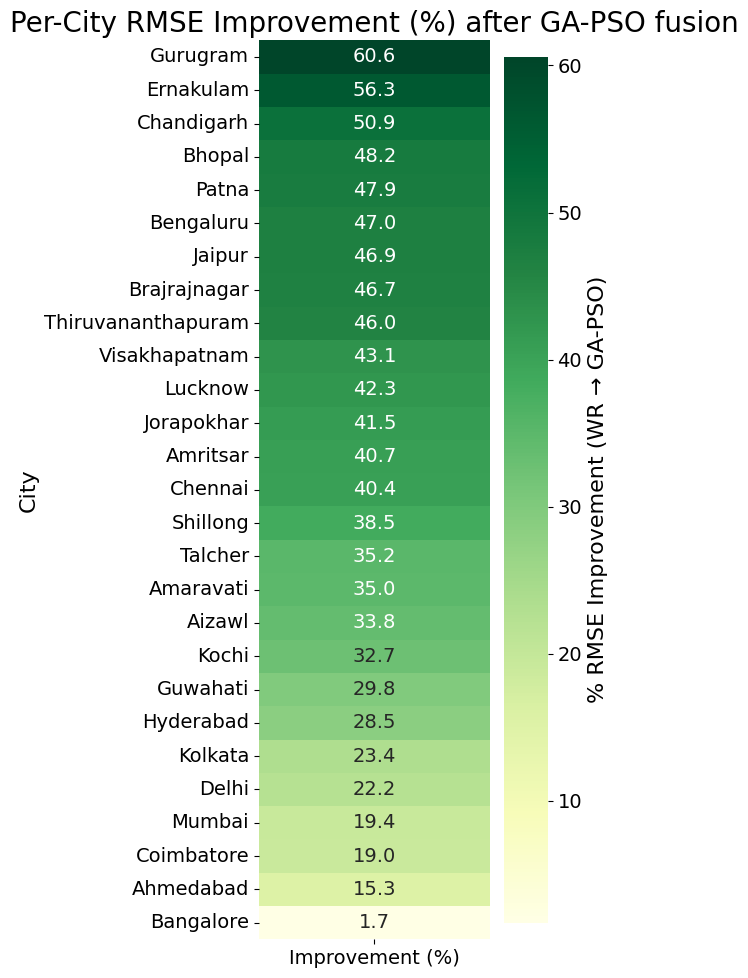

Saved: /content/India_AQI_workdir/results_citywise/figures/rmse_improvement_heatmap_GAPSO.png


,City,Improvement (%)
0,Gurugram,60.6
1,Ernakulam,56.3
2,Chandigarh,50.9
3,Bhopal,48.2
4,Patna,47.9
5,Bengaluru,47.0
6,Jaipur,46.9
7,Brajrajnagar,46.7
8,Thiruvananthapuram,46.0
9,Visakhapatnam,43.1


In [ ]:
# Figure: Per-city RMSE Improvement (%) after GA–PSO fusion
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
RESULTS_DIR = "/content/India_AQI_workdir/results_citywise"
FIG_DIR = os.path.join(RESULTS_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)
summary_file = os.path.join(RESULTS_DIR, "summary_metrics_all_models.csv")
df = pd.read_csv(summary_file)
# Filter only WR and GA-PSO results
wr = df[df["Model"] == "WR"].set_index("City")
gaps = df[df["Model"] == "GA-PSO"].set_index("City")
# Align cities
common_cities = wr.index.intersection(gaps.index)
wr = wr.loc[common_cities]
gaps = gaps.loc[common_cities]
# Compute RMSE improvement percentage
improvement_pct = (wr["RMSE"] - gaps["RMSE"]) / wr["RMSE"] * 100
improvement_pct = improvement_pct.sort_values(ascending=False)
# Prepare dataframe for heatmap
heat_df = improvement_pct.reset_index()
heat_df.columns = ["City", "Improvement (%)"]
heat_df["Improvement (%)"] = heat_df["Improvement (%)"].round(1)
# Plot heatmap
plt.figure(figsize=(6, 10))
sns.heatmap(
    heat_df.set_index("City"),
    annot=True, fmt=".1f",
    cmap="YlGn",
    cbar_kws={"label": "% RMSE Improvement (WR → GA-PSO)"}
)
plt.title("Per-City RMSE Improvement (%) after GA-PSO fusion")
plt.tight_layout()
out_path = os.path.join(FIG_DIR, "rmse_improvement_heatmap_GAPSO.png")
plt.savefig(out_path, dpi=600)
plt.show()
plt.close()
print("Saved:", out_path)
display(heat_df.head(10))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import glob
ref_all_list = []
fused_all_list = []
# Updated file pattern for GA–PSO best outputs
for f in glob.glob("/content/India_AQI_workdir/results_citywise/*_Best.csv"):
    df = pd.read_csv(f)
    # Auto-detect appropriate columns
    possible_ref_cols = ["Ref_AQI", "AQI_ref", "Reference_AQI"]
    possible_fuse_cols = ["Fused_AQI", "AQI_fused", "Optimized_AQI", "Fused"]
    ref_col = next((c for c in possible_ref_cols if c in df.columns), None)
    fused_col = next((c for c in possible_fuse_cols if c in df.columns), None)
    if ref_col and fused_col:
        ref_all_list.append(df[ref_col].values)
        fused_all_list.append(df[fused_col].values)
    else:
        print(f"Skipped — column mismatch in: {f}")
# Ensure we have valid data
if len(ref_all_list) == 0:
    print("No valid GA-PSO results found! Check column names.")
else:
    ref_all = np.concatenate(ref_all_list)
    fused_all = np.concatenate(fused_all_list)
    mask = ~np.isnan(ref_all) & ~np.isnan(fused_all)
    ref_all = ref_all[mask]
    fused_all = fused_all[mask]
    rmse = np.sqrt(mean_squared_error(ref_all, fused_all))
    corr, _ = pearsonr(ref_all, fused_all)
    print("Updated GLOBAL GA–PSO Metrics ")
    print("Pearson r =", round(corr, 3))
    print("RMSE =", round(rmse, 3))

Skipped — column mismatch in: /content/India_AQI_workdir/results_citywise/Patna_Best.csv
Skipped — column mismatch in: /content/India_AQI_workdir/results_citywise/Jorapokhar_Best.csv
Skipped — column mismatch in: /content/India_AQI_workdir/results_citywise/Mumbai_Best.csv
Skipped — column mismatch in: /content/India_AQI_workdir/results_citywise/Guwahati_Best.csv
Skipped — column mismatch in: /content/India_AQI_workdir/results_citywise/Kochi_Best.csv
Skipped — column mismatch in: /content/India_AQI_workdir/results_citywise/Amaravati_Best.csv
Skipped — column mismatch in: /content/India_AQI_workdir/results_citywise/Talcher_Best.csv
Skipped — column mismatch in: /content/India_AQI_workdir/results_citywise/Chandigarh_Best.csv
Skipped — column mismatch in: /content/India_AQI_workdir/results_citywise/Aizawl_Best.csv
Skipped — column mismatch in: /content/India_AQI_workdir/results_citywise/Coimbatore_Best.csv
Skipped — column mismatch in: /content/India_AQI_workdir/results_citywise/Ernakulam_

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

RESULTS_DIR = "/content/India_AQI_workdir/results_citywise"

results = []

best_files = sorted(glob.glob(os.path.join(RESULTS_DIR, "*_Best.csv")))

print("Found GA–PSO fused files:", len(best_files))

for f in best_files:

    city = os.path.basename(f).replace("_Best.csv", "")
    dfc = pd.read_csv(f, parse_dates=["Date"]).sort_values("Date")

    # Choose reference
    if "AQI_kf" in dfc.columns and not dfc["AQI_kf"].isna().all():
        ref_col = "AQI_kf"
    elif "AQI" in dfc.columns:
        ref_col = "AQI"
    else:
        continue

    if "fused_best" not in dfc.columns:
        continue
    if len(dfc) < 30:
        continue
    # 70/30 chronological split
    split_index = int(len(dfc) * 0.7)
    train_df = dfc.iloc[:split_index]
    test_df  = dfc.iloc[split_index:]
    train_rmse = np.sqrt(mean_squared_error(
        train_df[ref_col], train_df["fused_best"]
    ))
    test_rmse = np.sqrt(mean_squared_error(
        test_df[ref_col], test_df["fused_best"]
    ))
    gap_percent = abs(train_rmse - test_rmse) / train_rmse * 100
    results.append({
        "City": city,
        "Train_RMSE": train_rmse,
        "Test_RMSE": test_rmse,
        "RMSE_Gap_%": gap_percent
    })
results_df = pd.DataFrame(results)
print("\n TEMPORAL ROBUSTNESS SUMMARY (GA–PSO)")
print("Cities evaluated:", len(results_df))
print("Average Train RMSE:", round(results_df["Train_RMSE"].mean(), 3))
print("Average Test RMSE:", round(results_df["Test_RMSE"].mean(), 3))
print("Cities with RMSE gap < 10%:",
      round((results_df["RMSE_Gap_%"] < 10).mean() * 100, 2), "%")

Found GA–PSO fused files: 27

 TEMPORAL ROBUSTNESS SUMMARY (GA–PSO)
Cities evaluated: 27
Average Train RMSE: 62.349
Average Test RMSE: 67.933
Cities with RMSE gap < 10%: 48.15 %


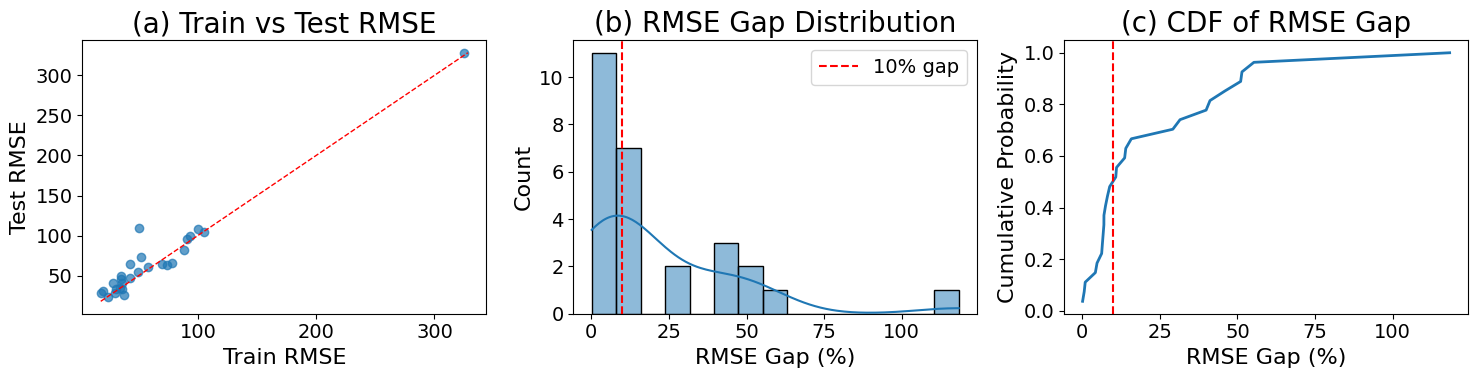

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = results_df.copy()
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# (a) Train vs Test RMSE
axes[0].scatter(df["Train_RMSE"], df["Test_RMSE"], alpha=0.7)
mn = min(df["Train_RMSE"].min(), df["Test_RMSE"].min())
mx = max(df["Train_RMSE"].max(), df["Test_RMSE"].max())
axes[0].plot([mn, mx], [mn, mx], 'r--', lw=1)
axes[0].set_xlabel("Train RMSE")
axes[0].set_ylabel("Test RMSE")
axes[0].set_title("(a) Train vs Test RMSE")
# (b) RMSE gap distribution
sns.histplot(df["RMSE_Gap_%"], bins=15, kde=True, ax=axes[1])
axes[1].axvline(10, color='r', linestyle='--', label='10% gap')
axes[1].set_xlabel("RMSE Gap (%)")
axes[1].set_title("(b) RMSE Gap Distribution")
axes[1].legend()
# (c) CDF of RMSE gap
sorted_gap = np.sort(df["RMSE_Gap_%"])
cdf = np.arange(1, len(sorted_gap)+1) / len(sorted_gap)
axes[2].plot(sorted_gap, cdf, lw=2)
axes[2].axvline(10, color='r', linestyle='--')
axes[2].set_xlabel("RMSE Gap (%)")
axes[2].set_ylabel("Cumulative Probability")
axes[2].set_title("(c) CDF of RMSE Gap")
plt.tight_layout()
plt.savefig("GA_PSO_Temporal_Robustness.png", dpi=300)
plt.show()